In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
digits = datasets.load_digits()

In [ ]:
X = digits.data

In [ ]:
X.shape

(1797, 64)

In [ ]:
y = digits.target

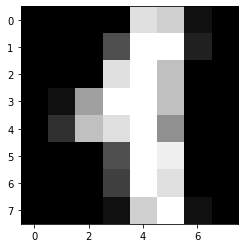

In [ ]:
plt.gray()
plt.imshow(X[11].reshape(8,8))

In [ ]:
# Train Test Split
#The reason to split before convoluting is to have same data across different architectures
X_train, X_test, y_train, y_test = X[:1257], X[1257:], y[:1257], y[1257:]

In [ ]:
def sigmoid(x: np.array) -> np.array:
  return 1 / (1 + np.exp(-x))

In [ ]:
def convolute(a:np.array, b:np.array) -> float:
  c = a * b
  return np.sum(c)

In [ ]:
def filt(input_mat, filter_mat, stride = 1, padding = 0):

  h_0, w_0 = input_mat.shape

  f = filter_mat.shape[0]

  output_mat = []

  if padding != 0:
    #Appending columns on both sides first
    zero_col = np.zeros((h_0, padding))

    #On the left side first
    input_mat = np.hstack((zero_col, input_mat))

    #On the right side
    input_mat = np.hstack((input_mat, zero_col))

    #Updating the dimension
    w_0 = input_mat.shape[1]

    #On the top side
    zero_row = np.zeros((padding, w_0))

    input_mat = np.vstack((zero_row, input_mat))

    #On the bottom side
    input_mat = np.vstack((input_mat, zero_row))

    #Updating the dimension
    h_0 = input_mat.shape[0]


  for h in range(0, h_0 - f + 1, stride):
    for w in range(0, w_0 - f + 1, stride):
        x = input_mat[h : h + f, w : w + f]

        #Convolution operation
        a = convolute(x, filter_mat)
        output_mat.append(a)


  #The dimensions of the output matrix
  w_1 = int(1 + (w_0 - f) / stride) # Since the dimensions are updated after padding
  h_1 = int(1 + (h_0 - f) / stride) # the padding term in ommitted from these formulas.

  output_mat = np.array(output_mat).reshape(h_1, w_1)

  return output_mat

In [ ]:
#Generic pooling function
def pooling(input_mat, pool_size = 1, stride = 1, padding = 0, pooling_type='max'):

  h_0, w_0 = input_mat.shape

  output_mat = []

  if padding != 0:
    #Appending columns on both sides first
    zero_col = np.zeros((h_0, padding))

    #On the left side first
    input_mat = np.hstack((zero_col, input_mat))

    #On the right side
    input_mat = np.hstack((input_mat, zero_col))

    #Updating the dimension
    w_0 = input_mat.shape[1]

    #On the top side
    zero_row = np.zeros((padding, w_0))

    input_mat = np.vstack((zero_row, input_mat))

    #On the bottom side
    input_mat = np.vstack((input_mat, zero_row))

    #Updating the dimension
    h_0 = input_mat.shape[0]

  if pooling_type == 'max':
    func = np.amax
  elif pooling_type == 'min':
    func = np.amin
  elif pooling_type == 'mean':
    func = np.mean
  elif pooling_type == 'median':
    func = np.median

  for h in range(0, h_0 - pool_size + 1, stride):
    for w in range(0, w_0 - pool_size + 1, stride):
      a = func(input_mat[h : h + pool_size, w : w + pool_size])
      output_mat.append(a)

  #The dimensions of the output matrix
  w_1 = int(1 + (w_0 - pool_size) / stride) # Since the dimensions are updated after padding,
  h_1 = int(1 + (h_0 - pool_size) / stride) # the padding term in ommitted from these formulas.

  output_mat = np.array(output_mat).reshape(h_1, w_1)

  return output_mat

In [ ]:
#Standard Filters

#Vertical Edge Detection filter
vert_edge_det = np.array([[1, 0, -1],
                          [1, 0, -1],
                          [1, 0, -1]])

#Horizontal Edge Detection Filter
hor_edge_det = np.array([[1, 1, 1],
                         [0, 0, 0],
                         [-1, -1, -1]])

#Sharpening filter
sharp_filt = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

#Scharr filter
scharr_filt = np.array([[3, 0, -3],
                        [10, 0, -10],
                        [3, 0, -3]])

#Gaussian Filter
gauss_ker = np.array([[1/16, 1/8, 1/16],
                      [1/8, 1/4, 1/8],
                      [1/16, 1/8, 1/16]])

### Scharr Filter without pooling

In [ ]:
train_conv_ = []

for i in range(X_train.shape[0]):

  #Generate feature map
  feat_map_1 = filt(X_train[i].reshape(8, 8), scharr_filt)

  train_conv_.append(np.hstack((X_train[i], feat_map_1.ravel())))

In [ ]:
train_conv_ = np.array(train_conv_)

In [ ]:
test_conv_ = []

for i in range(X_test.shape[0]):

  #Generate feature map
  feat_map_1 = filt(X_test[i].reshape(8, 8), scharr_filt)

  test_conv_.append(np.hstack((X_test[i], feat_map_1.ravel())))

In [ ]:
test_conv_ = np.array(test_conv_)

#### RF

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)

rfc_parameters = {'n_estimators': range(10,100,10),
                  'max_depth': range(1,10),
                  'min_samples_split': range(2,10)}

In [ ]:
rf_grid = GridSearchCV(rfc, param_grid=rfc_parameters, cv=KFold(3))

rf_grid.fit(train_conv_, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'n_estimators': range(10, 100, 10)})

In [ ]:
print("Best parameters:", rf_grid.best_params_)
print("Best training score:", rf_grid.best_score_)

Best parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 90}
Best training score: 0.9276054097056484


In [ ]:
rf_clf = rf_grid.best_estimator_
rf_predicted = rf_clf.predict(test_conv_)
rf_predict_prob = rf_clf.predict_proba(test_conv_)

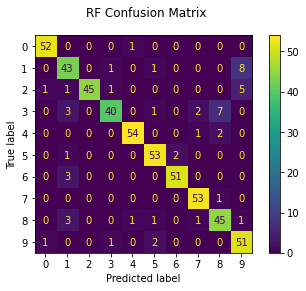

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, rf_predicted)
disp.figure_.suptitle("RF Confusion Matrix")

plt.show()

In [ ]:
print(
    f"RF Classification report for classifier {rf_clf}:\n"
    f"{metrics.classification_report(y_test, rf_predicted)}\n"
)

RF Classification report for classifier RandomForestClassifier(max_depth=8, min_samples_split=5, n_estimators=90,
                       n_jobs=-1):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.80      0.81      0.80        53
           2       1.00      0.85      0.92        53
           3       0.93      0.75      0.83        53
           4       0.96      0.95      0.96        57
           5       0.91      0.95      0.93        56
           6       0.96      0.94      0.95        54
           7       0.93      0.98      0.95        54
           8       0.82      0.87      0.84        52
           9       0.78      0.93      0.85        55

    accuracy                           0.90       540
   macro avg       0.91      0.90      0.90       540
weighted avg       0.91      0.90      0.90       540




In [ ]:
rf_pred = pd.DataFrame(rf_predict_prob, columns=range(10))
rf_pred['predicted'] = rf_predicted
rf_pred['ground_truth'] = y_test

rf_pred.head()

,0,1,2,3,4,5,6,7,8,9,predicted,ground_truth
0,0.051831,0.008502,0.000000,0.000000,0.886713,0.000172,0.025088,0.027273,0.000000,0.000422,4,4
1,0.797067,0.000000,0.000000,0.000538,0.011235,0.083564,0.008941,0.004762,0.066144,0.027750,0,0
2,0.000000,0.017424,0.000000,0.000000,0.004167,0.887639,0.022186,0.012580,0.054721,0.001282,5,5
3,0.000000,0.034758,0.050498,0.848399,0.001220,0.005033,0.000000,0.005358,0.048976,0.005759,3,3
4,0.010185,0.003333,0.006667,0.006667,0.008606,0.001984,0.952638,0.004762,0.005159,0.000000,6,6


In [ ]:
corr_class_rf = rf_pred.loc[rf_pred['predicted'] == rf_pred['ground_truth']].index
incorr_class_rf = rf_pred.loc[rf_pred['predicted'] != rf_pred['ground_truth']].index

In [ ]:
top_best_classified = rf_pred.iloc[corr_class_rf, :10].max(axis=1).nlargest(25).index

In [ ]:
#These indices have been hand picked since 0's were predicted with highest probability
disp_ind = [50, 223, 412, 417, 516, 241]

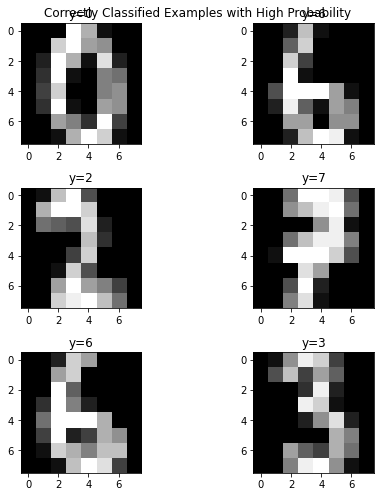

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(7, 7))
fig.subplots_adjust(bottom=0, top=0.92, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axes.flatten()):
  ax.imshow(X_test[disp_ind[i]].reshape(8,8))
  ax.set_title(f"y={y_test[disp_ind[i]]}")
plt.suptitle("Correctly Classified Examples with High Probability")
plt.tight_layout();

In [ ]:
disp_ind = np.random.choice(incorr_class_rf, size=6)
disp_ind

array([336, 371, 228, 455, 331, 532])

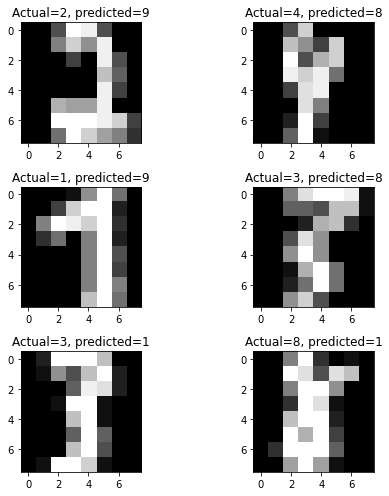

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(7, 7))
fig.subplots_adjust(bottom=0, top=0.92, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axes.flatten()):
  ax.imshow(X_test[disp_ind[i]].reshape(8,8))
  ax.set_title(f"Actual={y_test[disp_ind[i]]}, predicted={rf_predicted[disp_ind[i]]}")
# plt.suptitle("InCorrectly Classified Examples with High Probability")
plt.tight_layout();

#### XGB

In [ ]:
xgb = GradientBoostingClassifier()

xgb_parameters = {'n_estimators': range(1,10),
                  'max_depth':range(1,10),
                  'min_samples_split':range(2,10)}

In [ ]:
xgb_grid = GridSearchCV(xgb, param_grid=xgb_parameters, cv=KFold(3), n_jobs=-1)

xgb_grid.fit(train_conv_, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'n_estimators': range(1, 10)})

In [ ]:
print("Best parameter:", xgb_grid.best_params_)
print("Best training score:", xgb_grid.best_score_)

Best parameter: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 9}
Best training score: 0.8146380270485283


In [ ]:
xgb_clf = xgb_grid.best_estimator_

In [ ]:
# Predict the value of the digit on the test subset
xgb_predicted = xgb_clf.predict(test_conv_)
xgb_predict_prob = xgb_clf.predict_proba(test_conv_)

In [ ]:
print(
    f"XGB Classification report for classifier {xgb_clf}:\n"
    f"{metrics.classification_report(y_test, xgb_predicted)}\n"
)

XGB Classification report for classifier GradientBoostingClassifier(min_samples_split=5, n_estimators=9):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        53
           1       0.77      0.83      0.80        53
           2       0.86      0.79      0.82        53
           3       0.74      0.74      0.74        53
           4       0.87      0.82      0.85        57
           5       0.89      0.89      0.89        56
           6       0.83      0.74      0.78        54
           7       0.88      0.91      0.89        54
           8       0.67      0.85      0.75        52
           9       0.83      0.71      0.76        55

    accuracy                           0.82       540
   macro avg       0.83      0.82      0.82       540
weighted avg       0.83      0.82      0.82       540




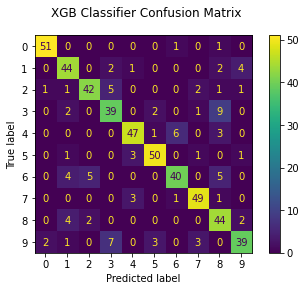

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, xgb_predicted)
disp.figure_.suptitle("XGB Classifier Confusion Matrix")

plt.show()

In [ ]:
xgb_pred = pd.DataFrame(xgb_predict_prob, columns=range(10))
xgb_pred['predicted'] = xgb_predicted
xgb_pred['ground_truth'] = y_test

xgb_pred.head()

,0,1,2,3,4,5,6,7,8,9,predicted,ground_truth
0,0.025305,0.028705,0.025915,0.026360,0.762130,0.026435,0.025468,0.026264,0.025663,0.027754,4,4
1,0.759145,0.028546,0.025772,0.026215,0.025233,0.027838,0.025433,0.026119,0.025548,0.030152,0,0
2,0.022844,0.025696,0.022630,0.023797,0.022906,0.698476,0.023871,0.022878,0.111308,0.025593,5,5
3,0.023960,0.026268,0.046788,0.746303,0.024026,0.024642,0.024301,0.024153,0.029389,0.030170,3,3
4,0.025022,0.028384,0.025625,0.026066,0.025090,0.027772,0.753859,0.025971,0.035267,0.026943,6,6


In [ ]:
corr_class_xgb = xgb_pred.loc[xgb_pred['predicted'] == xgb_pred['ground_truth']].index
incorr_class_xgb = xgb_pred.loc[xgb_pred['predicted'] != xgb_pred['ground_truth']].index

In [ ]:
top_best_classified = xgb_pred.iloc[corr_class_xgb, :10].max(axis=1).nlargest(25).index
top_best_classified

Int64Index([275,  63, 452, 466, 451,  77, 292, 394, 302, 293, 142,  96, 377,
            193, 457, 427, 454, 368,  24, 267, 495,  13, 290, 190, 218],
           dtype='int64')

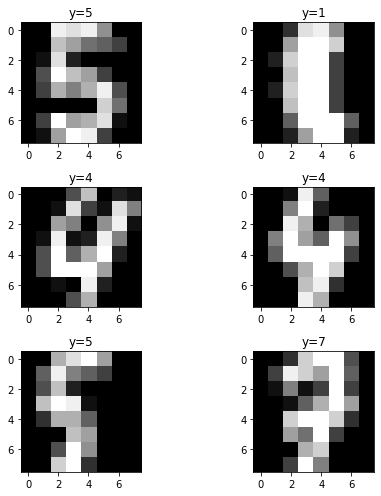

In [ ]:
disp_ind = [275, 452, 451, 292, 293, 142]

fig, axes = plt.subplots(3, 2, figsize=(7, 7))
fig.subplots_adjust(bottom=0, top=0.92, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axes.flatten()):
  ax.imshow(X_test[disp_ind[i]].reshape(8,8))
  ax.set_title(f"y={y_test[disp_ind[i]]}")
# plt.suptitle("Correctly Classified Examples with High Probability")
plt.tight_layout();

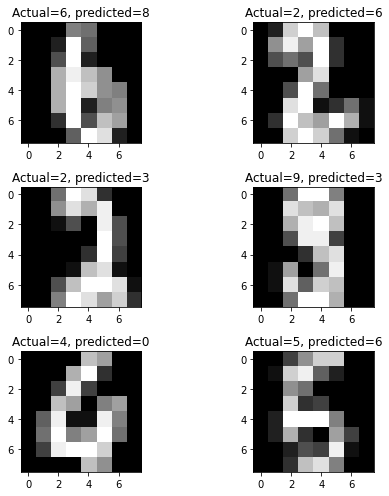

In [ ]:
disp_ind = np.random.choice(incorr_class_xgb, size=6)
disp_ind

fig, axes = plt.subplots(3, 2, figsize=(7, 7))
fig.subplots_adjust(bottom=0, top=0.92, hspace=0.05, wspace=0.05)

for i, ax in enumerate(axes.flatten()):
  ax.imshow(X_test[disp_ind[i]].reshape(8,8))
  ax.set_title(f"Actual={y_test[disp_ind[i]]}, predicted={xgb_predicted[disp_ind[i]]}")
# plt.suptitle("InCorrectly Classified Examples with High Probability")
plt.tight_layout();

Reference for confusion matrix & visualization code: https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html